## TensorFlow 实现进阶的卷积网络

### Cifar-10 数据集
    是一个经典的数据集,包含约60000张32x32的彩色图片.训练集50000张,测试集10000张.标注10个类.还有一个版本Cifar-100,标注了100个类.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from utils.cifar10_utils import *

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'utils/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print("Training data shape: ", X_train.shape)
print("Training labels shape: ", y_train.shape)
print("Test data shape: ", X_test.shape)
print("Test labels shape: ", y_test.shape)

Training data shape:  (10000, 32, 32, 3)
Training labels shape:  (10000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

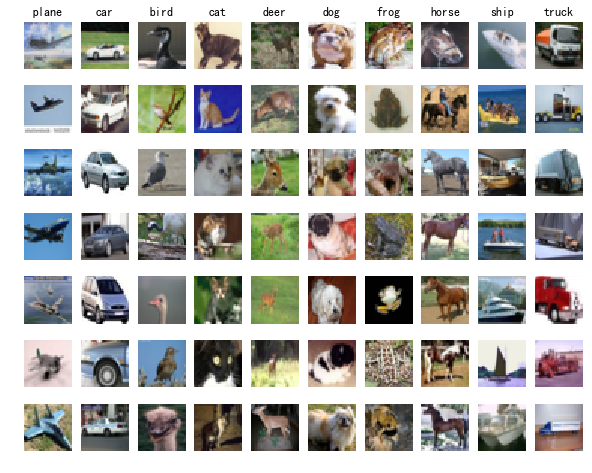

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
sample_num_cls = 7
# a Set means label and val
for cur_item_label_InVal, cur_item_label_InName in enumerate(classes):
    cur_item_set_Inytrain = np.flatnonzero(cur_item_label_InVal==y_train)
    cur_item_set_Rd7Ofytrain = np.random.choice(cur_item_set_Inytrain, sample_num_cls, replace=False)

    for set_pos, item_set_Val in enumerate(cur_item_set_Rd7Ofytrain):
        plt_idx = set_pos*num_classes+cur_item_label_InVal+1
        plt.subplot(sample_num_cls, num_classes, plt_idx)
        plt.imshow(X_train[item_set_Val].astype('uint8'))
        plt.axis('off')
        if set_pos == 0:
            plt.title(cur_item_label_InName)# 这个地方容易理解错
    
plt.show()

### 用tf来加载cifar10

这个tf的工具实现了对图片的翻转, 随机剪切等数据增强方法.

In [5]:
#!cd models/tutorials/image/cifar10/
import sys
#sys.path.append('models/tutorials/image/cifar10/') 

In [6]:
#from models.tutorials.image.cifar10.cifar10 import *
import cifar10,cifar10_input
import tensorflow as tf
import time

In [7]:
batch_size  = 3000
max_rounds = 20#160#3000
data_dir = 'tmp/cifar10_data/cifar-10-batches-bin/cifar-10-batches-bin'
tf.app.flags.FLAGS.data_dir = data_dir

In [8]:
#!mkdir -p tmp/cifar10_data/cifar-10-batches-bin/

#### 1. 定义一个带L2正则的权重变量

In [9]:
def variable_weights_withL2loss(shape, stddev, wl):
    var = tf.Variable(tf.truncated_normal(shape, stddev=stddev))
    if wl is not None:
        weight_loss = tf.multiply(tf.nn.l2_loss(var),wl,name='weight_loss')
        tf.add_to_collection('losses',weight_loss)
    
    return var

#### 2. 加载cifar数据并翻转剪切

In [10]:
cifar10.maybe_download_and_extract()

In [11]:
images_train, labels_train = cifar10_input.distorted_inputs(data_dir,batch_size)

Filling queue with 20000 CIFAR images before starting to train. This will take a few minutes.


#### 3.生成测试数据

In [12]:
image_test, label_test =cifar10_input.inputs(eval_data=True,data_dir=data_dir,batch_size=batch_size)


#### 4. 输入数据创建

注意: label_holder这个是int64类型的,如果类型不对后面会报错,注意看tf给的错误提示.

In [13]:
image_holder = tf.placeholder(tf.float32, [batch_size, 24,24,3])#输入源: 24x24尺寸,rgb3色
label_holder = tf.placeholder(tf.int64, [batch_size])

#### 5.第一个网络

输入: batch_size x 24x24 x3

权重: (3x5x5) x 64

含义： 有64组W（w0...w63)

每个w中含有3个子成员,

分别对应输入的r,g,b三个通道.


输出: batch_size  x  w/2 x h/2 * 64

tf.nn.max_pool
> tf.nn.max_pool
  第一个参数是输入,一般pool接在conv之后,conv的结果.shape依然是[batch,w,h,channel]
  第二个参数是ksize, 一般我们不希望在batch和channel通道上做pool,这里的值为1.然后选择kernel的大小.
  第三个参数是步长,如果strides的w,h都是1,1的话,那么输出将不会有deci的效果.
  第四个参数是pool对边界像素的处理方法.有加padding的,也有不加的.

In [14]:
w1 = variable_weights_withL2loss(shape=[5,5,3,64],stddev=5e-2,wl=0.0)
k1 = tf.nn.conv2d(image_holder, w1, [1,1,1,1],padding='SAME')
b1 = tf.Variable(tf.constant(0.0,shape=[64]))
conv1 = tf.nn.bias_add(k1,b1)
conv1 = tf.nn.relu(conv1)
pool1 = tf.nn.max_pool(conv1, ksize=[1,3,3,1],strides=[1,2,2,1],padding='SAME')
norm1 = tf.nn.lrn(pool1,depth_radius=4,bias=1.0,alpha=0.001/9.0,beta=0.75)

#### 6.第二个网络

输入: batch_size x w/2 x h/2 x 64

权重: (64x5x5) x 64

输出: w/4 x h/4 x 64


In [15]:
w2 = variable_weights_withL2loss([5,5,64,64],stddev=0.1,wl=0.2)
k2 = tf.nn.conv2d(norm1,w2,strides=[1,1,1,1],padding='SAME')
b2 = tf.Variable(tf.constant(0.0, shape=[64]))
conv2 = tf.nn.bias_add(k2, b2)
conv2 = tf.nn.relu(conv2)
norm2 = tf.nn.lrn(conv2,depth_radius=4,bias=1,alpha=0.001/0.9,beta=0.75)
pool2 = tf.nn.max_pool(norm2,ksize=[1,3,3,1],strides=[1,2,2,1],padding='SAME')

#### 7.全连接层A
把二维的拉成一维的,用之前的经典神经网络来做,就叫做全连接层.

之前的是 w/4 x h/4 x 64
我们把 w/4 x h/4 x 64这个值,拉成一共有 batch_size个行.
最初始的值是: batch_size 个图片,每个图片的宽高为24x24,共3通道
batch_size x 24 x 24 x 3

输入: batch_size x dim 

$$ c = \frac{S}{r}$$
其中,c为dim, r为batch_size, S为pool2的总数量

权重: dim x 384 (隐含层节点个数)

输出: batch_size x 384

In [16]:
image_reshape = tf.reshape(pool2,shape=[batch_size,-1]) #列不管,把行拉成batch_size个。这个也是说有batch_size个图像，每一行是一个图像。
dim = image_reshape.get_shape()[1].value
w3 = variable_weights_withL2loss(shape=[dim,384],stddev=0.1,wl=0.1)
b3 = tf.Variable(tf.constant(0.1, shape=[384]))
hidden3 = tf.matmul(image_reshape,w3) + b3
hidden3 = tf.nn.relu(hidden3)

#### 8.全连接层B

输入: batch_size x 384

权重: 384x192

输出: batch_size x 192


In [17]:
w4 = variable_weights_withL2loss(shape=[384,192],stddev=0.1,wl=0.1)
b4 = tf.Variable(tf.constant(0.1,shape=[192]))
hidden4 = tf.matmul(hidden3,w4) + b4
hidden4 = tf.nn.relu(hidden4)

#### 9.最后一层

输入: batch_size x 192

权重: 192x10

输出: batch_size x 10

In [18]:
w5 = variable_weights_withL2loss(shape=[192,10],stddev=0.1, wl=0.1)
b5 = tf.Variable(tf.constant(0.0,shape=[10]))
out = tf.add(tf.matmul(hidden4,w5),b5)


#### 10. 损失函数的定义

一般cnn都喜欢用交叉熵来做信息的损失函数.交叉熵越大说明事件的不确定性越大.比如抛硬币,正反都是1/2,这样的交叉熵也特别大,对应的事件的不确定性越大.


In [19]:
def loss(logist, labels):
    labels = tf.cast(labels, tf.int64)
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,logits=logist,name = 'cross_entropy')
    cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy_mean')
    tf.add_to_collection('losses',cross_entropy_mean)
    
    return tf.add_n(tf.get_collection('losses'), name='total_loss')


#### 11. 三板斧,loss和opt


In [20]:
loss_val = loss(logist=out, labels=label_holder)
train_op = tf.train.AdagradOptimizer(1e-3).minimize(loss_val)
top_k_op = tf.nn.in_top_k(out,label_holder, 1)
top_k_op

<tf.Tensor 'in_top_k/InTopKV2:0' shape=(3000,) dtype=bool>

#### 12.1 开始tf的sess


In [21]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

#### 12.2 启动图片数据增强的加速线程,默认使用16个线程.

图片增强,就是前面的对数据集的翻转,裁剪等操作.

In [22]:
tf.train.start_queue_runners()

[<Thread(QueueRunnerThread-input_producer-input_producer/input_producer_EnqueueMany, started daemon 139950636922624)>,
 <Thread(QueueRunnerThread-shuffle_batch/random_shuffle_queue-shuffle_batch/random_shuffle_queue_enqueue, started daemon 139950628529920)>,
 <Thread(QueueRunnerThread-shuffle_batch/random_shuffle_queue-shuffle_batch/random_shuffle_queue_enqueue, started daemon 139950620137216)>,
 <Thread(QueueRunnerThread-shuffle_batch/random_shuffle_queue-shuffle_batch/random_shuffle_queue_enqueue, started daemon 139950611744512)>,
 <Thread(QueueRunnerThread-shuffle_batch/random_shuffle_queue-shuffle_batch/random_shuffle_queue_enqueue, started daemon 139950603351808)>,
 <Thread(QueueRunnerThread-shuffle_batch/random_shuffle_queue-shuffle_batch/random_shuffle_queue_enqueue, started daemon 139950594959104)>,
 <Thread(QueueRunnerThread-shuffle_batch/random_shuffle_queue-shuffle_batch/random_shuffle_queue_enqueue, started daemon 139950586566400)>,
 <Thread(QueueRunnerThread-shuffle_batch/

In [23]:
for step in range(max_rounds):
    start_time = time.time()
    image_batch, label_batch = sess.run([images_train,labels_train])
    loss_value = sess.run([train_op,loss_val],feed_dict={image_holder:image_batch, label_holder:label_batch})
    duration = time.time() - start_time
    if step % 10 == 0:
        example_per_sec = batch_size/duration
        sec_per_batch = float(duration)
        
        print("step,example_per_sec, sec_per_batch", step, example_per_sec, sec_per_batch)

step,example_per_sec, sec_per_batch 0 313.0136087865721 9.584247827529907
step,example_per_sec, sec_per_batch 10 462.2652035085083 6.489781141281128


#### 13. 预测


In [27]:
num_example = 10000
import math
num_iter = int(math.ceil(num_example/batch_size))
real_example = num_iter * batch_size
step = 0

while step < num_iter:
    image_test_batch, label_test_batch = sess.run([image_test,label_test])
    test_pred_ret = sess.run([top_k_op],feed_dict={image_holder:image_test_batch, label_holder:label_test_batch})
    temp = np.sum(test_pred_ret)
    step += 1

precision = temp/real_example
print("precision",precision)

precision 0.036333333333333336


## 总结

#### 卷积层

目前卷积层主要做的是特征提取.这部分是之前传统算法的领域,比如fd部分,传统方法是做haar算法实现.现在利用卷积层去自己训练发现特征.
